# Directional Filtered Complex Statistics Descriptor — DUD-E Dataset

This notebook implements a **Directional Persistent Homology (DPH)** descriptor, which extends traditional persistent homology by incorporating **directional projections** over multiple fixed axes (x, y, z).  

Each molecule (ligand or decoy) is represented as a 3D point cloud, and we analyze its topological changes as we sweep through the molecule along different spatial directions.  

Pipeline Overview:
1. Load 3D molecular point clouds (ligands + decoys)
2. Project along x, y, z directions and compute persistence diagrams (H₀ + H₁)
3. Aggregate statistics over multiple thresholds
4. Train ML models — Logistic Regression, Random Forest, SVM (RBF), XGBoost
5. Evaluate with **AUC** and **Enrichment Factor (EF%)**


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.stats import iqr
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the path to the extracted directory
targets_dir = r'C:\Users\kanis\Desktop\Python\Computational Geometry and Topology for Drug Discovery\DUD-E\DUDE_diverse_pointClouds\DUDE_diverse_pointClouds'

# List and sort the contents (targets)
targets = sorted(os.listdir(targets_dir))
print("Targets found:", targets)

Targets found: ['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']


## 1. Dataset Loading and Verification

We use the **DUD-E (Directory of Useful Decoys, Enhanced)** dataset.  
Each protein target contains:
- **Ligands** — active molecules
- **Decoys** — similar in physicochemical properties but inactive  

We verify dataset structure and ensure the ligand/decoy counts are correct for the chosen target (e.g., `akt1`).


In [3]:
# Define paths to ligand and decoy folders
ligands_path = os.path.join(targets_dir, "akt1", "ligs")
decoys_path = os.path.join(targets_dir, "akt1", "decoys")

# List files
ligands_1 = os.listdir(ligands_path)
decoys_1 = os.listdir(decoys_path)

# Print counts
print(f"Number of ligand files: {len(ligands_1)}")
print(f"Number of decoy files: {len(decoys_1)}")


Number of ligand files: 293
Number of decoy files: 16444


## 2. Directional Geometry Setup

To introduce geometric context, we analyze each molecule along three orthogonal unit vectors:
- X-axis: captures molecular width
- Y-axis: captures height
- Z-axis: captures depth  

For each direction, atoms are projected, and partial subclouds are extracted at various height thresholds.  
This process reveals **directional topological patterns** missed by isotropic descriptors.


In [4]:
# Generate fixed unit direction vectors (x, y, z)
def generate_fixed_unit_directions():
    return [
        np.array([1.0, 0.0, 0.0]),  # x-axis
        np.array([0.0, 1.0, 0.0]),  # y-axis
        np.array([0.0, 0.0, 1.0])   # z-axis
    ]

# Normalize vectors 
def normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-12)

## 3. Persistent Homology Computation (H₀ + H₁)

For every directional subcloud:
- Compute **persistent homology** using the `ripser` library (`maxdim=1`)
- Extract **H₀ (connected components)** and **H₁ (loops)** diagrams  
- Summarize each diagram with 38 statistical measures:
  - Mean, Std, Median, IQR, Range
  - Quantiles (10%, 25%, 75%, 90%)
  - Count and Entropy

Each subcloud yields 76 features (38 from H₀ + 38 from H₁), concatenated across all directions and thresholds.

In [5]:
# Compute persistence statistics
def persistence_statistics(diagram):
    if len(diagram) == 0:
        return np.zeros(38)

    births = diagram[:, 0]
    deaths = diagram[:, 1]
    mids = (births + deaths) / 2
    lives = deaths - births

    def stats(x):
        return [
            np.mean(x), np.std(x), np.median(x), iqr(x), np.ptp(x),
            *np.percentile(x, [10, 25, 75, 90])
        ]

    L = np.sum(lives)
    prob = lives / (L + 1e-12)
    entropy = -np.sum(prob * np.log(prob + 1e-12))

    vec = stats(births) + stats(deaths) + stats(mids) + stats(lives) + [len(lives), entropy]
    return np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)


In [6]:
def directional_persistence_stats(atom_positions, r=1.7, directions=30, thresholds=5):
    dirs = generate_fixed_unit_directions()
    all_vecs = []

    for v in dirs:
        heights = atom_positions @ v.T
        for threshold in np.linspace(np.min(heights), np.max(heights), thresholds):
            idx = np.where(heights <= threshold)[0]
            if len(idx) < 2:
                continue
            cloud = atom_positions[idx]
            
            # Compute both H₀ and H₁
            result = ripser(cloud, maxdim=1, thresh=r) 
            h0 = persistence_statistics(result['dgms'][0])
            h1 = persistence_statistics(result['dgms'][1]) if len(result['dgms']) > 1 else np.zeros(38)
            
            all_vecs.append(np.concatenate([h0, h1]))  # Combined features

    if not all_vecs:
        return np.zeros(38 * 2 * directions * thresholds)  # Double size for H₀+H₁
    
    return np.concatenate(all_vecs)

## 4. Feature Extraction

The function `extract_dude_features_directional()`:
- Reads ligand/decoy `.csv` point clouds
- Computes directional persistent homology vectors
- Pads feature lengths to ensure consistent dimensionality
- Labels data (`1 = ligand`, `0 = decoy`)

The resulting DataFrame contains one feature vector per molecule, ready for scaling and model training.

In [7]:
# Feature extraction from files

def extract_dude_features_directional(file_list, directory, label, r=1.7, directions=None, thresholds=5):
    data = []
    max_len = 0

    for file in file_list:
        try:
            df = pd.read_csv(os.path.join(directory, file), header=None)
            atom_positions = df.iloc[:, :3].values
            if atom_positions.shape[0] < 2:
                continue
            feat_vec = directional_persistence_stats(atom_positions, r, directions, thresholds)
            max_len = max(max_len, len(feat_vec))
            data.append((feat_vec, label))
        except Exception as e:
            print(f"Error in {file}: {e}")
            continue

    rows = []
    for feat_vec, lbl in data:
        if len(feat_vec) < max_len:
            feat_vec = np.pad(feat_vec, (0, max_len - len(feat_vec)), 'constant')
        rows.append(list(feat_vec) + [lbl])

    if not rows:
        return pd.DataFrame()

    columns = [f'dps_{i+1}' for i in range(max_len)] + ['label']
    return pd.DataFrame(rows, columns=columns)

**Observation:**  
Directional PH descriptors produce large but stable feature vectors that capture anisotropic structural information across molecular orientations.


## 5. Evaluation Metrics

We evaluate each model using:
- **ROC–AUC:** global classification quality
- **Enrichment Factor (EF%)** at 15% top-ranked samples, measuring early enrichment.

This EF% implementation directly compares the top 15% ranked predictions to a random baseline, indicating model effectiveness in early retrieval.


In [8]:
# Enrichment factor calculation

def enrichment_factor(y_true, y_probs, top_percent=1):
    N = len(y_true)
    top_n = int(N * (top_percent / 100))
    sorted_idx = np.argsort(y_probs)[::-1][:top_n]
    hits = np.sum(np.array(y_true)[sorted_idx])
    total_actives = np.sum(y_true)
    ef = (hits / top_n) / (total_actives / N)
    return ef


## 6. Model Training and ROC Visualization

For each target, we:
1. Split ligands and decoys (80/20 train-test)
2. Balance classes via resampling
3. Standardize features (Z-score)
4. Train four models:
   - Logistic Regression  
   - Random Forest  
   - SVM (RBF Kernel)  
   - XGBoost  

Each model’s ROC curve is plotted per target.
Higher curves and AUC values indicate better ligand–decoy discrimination.

In [9]:
def run_pipeline_for_target(target_path, r=1.7, directions=None, thresholds=5):
    if directions is None:
        directions = generate_fixed_unit_directions()

    lig_dir = os.path.join(target_path, 'ligs')
    decoy_dir = os.path.join(target_path, 'decoys')
    lig_files = os.listdir(lig_dir)
    decoy_files = os.listdir(decoy_dir)

    train_lig, test_lig = train_test_split(lig_files, test_size=0.2, random_state=42)
    train_dec, test_dec = train_test_split(decoy_files, test_size=0.2, random_state=42)

    train_dec = resample(train_dec, replace=False, n_samples=len(train_lig), random_state=42)
    test_dec = resample(test_dec, replace=False, n_samples=len(test_lig), random_state=42)

    train_lig_df = extract_dude_features_directional(train_lig, lig_dir, 1, r, directions, thresholds)
    train_dec_df = extract_dude_features_directional(train_dec, decoy_dir, 0, r, directions, thresholds)
    test_lig_df = extract_dude_features_directional(test_lig, lig_dir, 1, r, directions, thresholds)
    test_dec_df = extract_dude_features_directional(test_dec, decoy_dir, 0, r, directions, thresholds)

    train_df = pd.concat([train_lig_df, train_dec_df]).sample(frac=1, random_state=42).reset_index(drop=True)
    test_df = pd.concat([test_lig_df, test_dec_df]).sample(frac=1, random_state=42).reset_index(drop=True)

    common_cols = list(set(train_df.columns) & set(test_df.columns))
    if 'label' in common_cols:
        common_cols.remove('label')
    train_df = train_df[[*sorted(common_cols), 'label']]
    test_df = test_df[[*sorted(common_cols), 'label']]

    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]
    X_test = test_df.drop("label", axis=1)
    y_test = test_df["label"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(probability=True),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    model_results = []
    plt.figure(figsize=(6, 5))

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, probs)
        ef = enrichment_factor(y_test, probs, top_percent=15)
        fpr, tpr, _ = roc_curve(y_test, probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")
        model_results.append({
            'Model': model_name,
            'AUC': round(auc, 4),
            'EF%': round(ef, 3)
        })

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"{os.path.basename(target_path)} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(model_results)

## 7. Cross-target Evaluation

We iterate over all protein targets in DUD-E.  
Each target is processed independently, yielding its own AUC and EF% summary.

The final aggregated DataFrame consolidates all results for comparison across targets.

In [10]:
# Master loop for all targets

def run_all_targets(base_path):
    all_results = []
    targets = sorted(os.listdir(base_path))
    directions = generate_fixed_unit_directions()

    for target in targets:
        print(f"\nProcessing target: {target}")
        target_path = os.path.join(base_path, target)
        try:
            target_results = run_pipeline_for_target(target_path, r=1.7, directions=directions, thresholds=3)
            target_results["Target"] = target
            all_results.append(target_results)
        except Exception as e:
            print(f"Error processing {target}: {e}")

    print("\nSummary of all AUC and EF results:")
    for df in all_results:
        target = df['Target'].iloc[0]
        print(f"\n--- {target.upper()} ---")
        print(df[["Model", "AUC", "EF%"]].to_string(index=False))  # Use display() in Jupyter if preferred

    return pd.concat(all_results, ignore_index=True)



Processing target: akt1


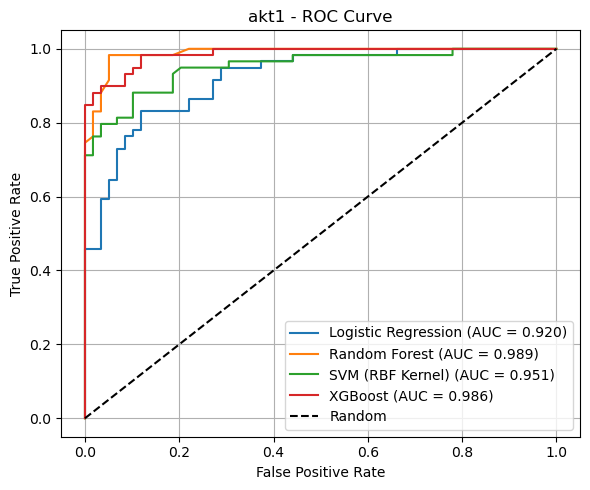


Processing target: ampc


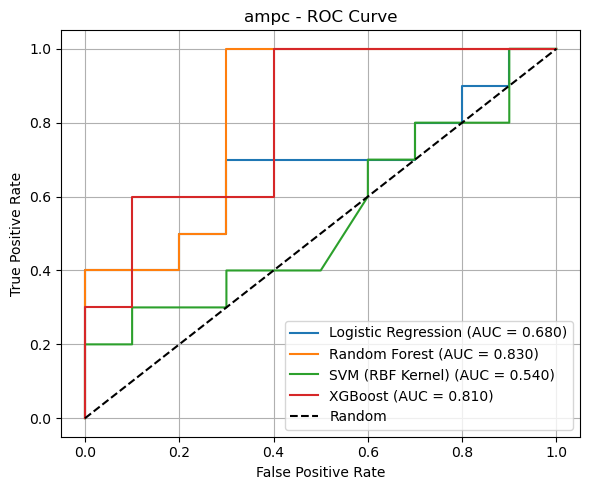


Processing target: cp3a4


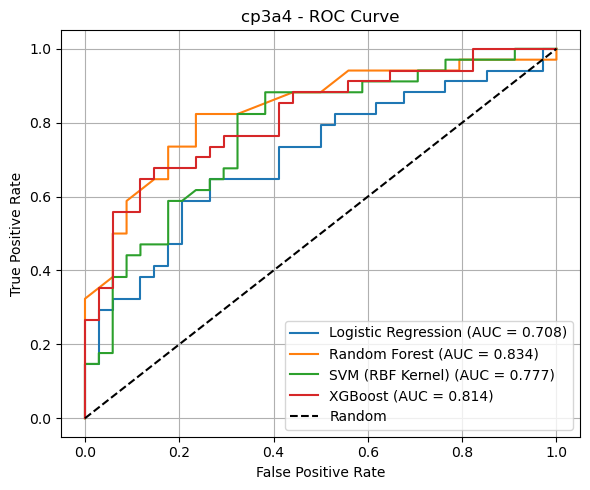


Processing target: cxcr4


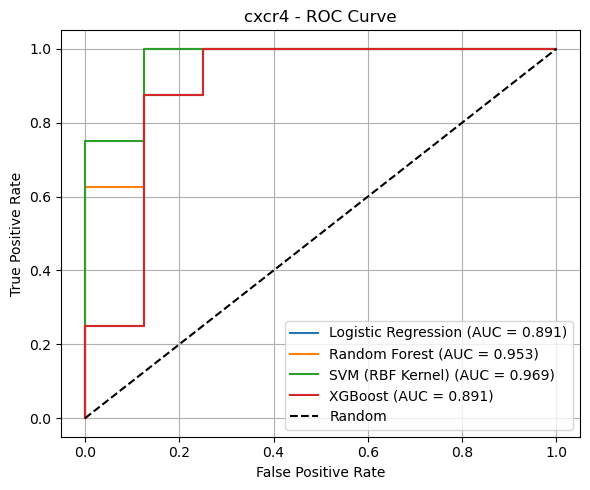


Processing target: gcr


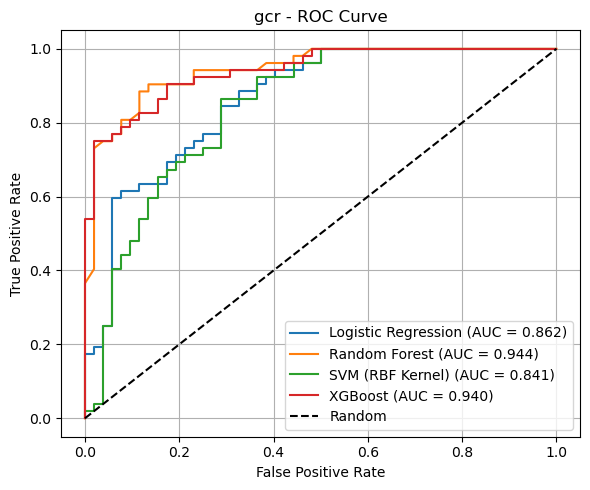


Processing target: hivpr


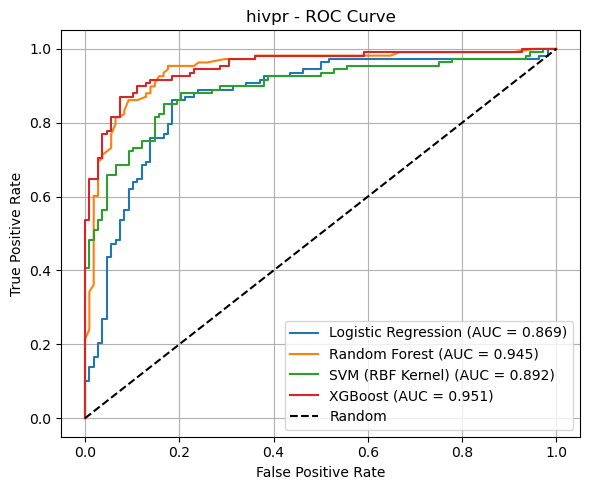


Processing target: hivrt


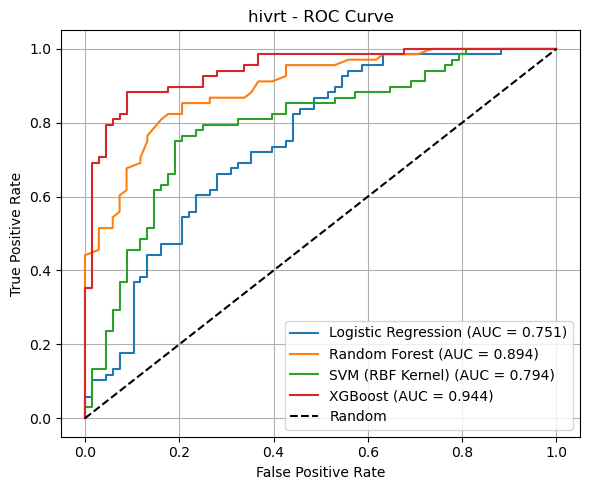


Processing target: kif11


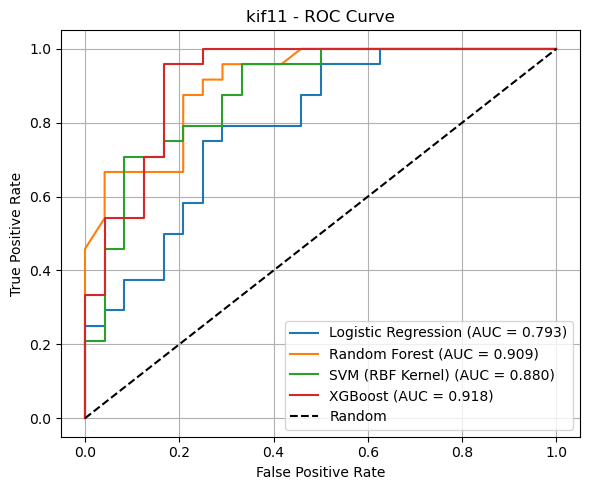


Summary of all AUC and EF results:

--- AKT1 ---
              Model    AUC  EF%
Logistic Regression 0.9204  2.0
      Random Forest 0.9887  2.0
   SVM (RBF Kernel) 0.9513  2.0
            XGBoost 0.9856  2.0

--- AMPC ---
              Model  AUC   EF%
Logistic Regression 0.68 2.000
      Random Forest 0.83 2.000
   SVM (RBF Kernel) 0.54 1.333
            XGBoost 0.81 2.000

--- CP3A4 ---
              Model    AUC  EF%
Logistic Regression 0.7085  1.8
      Random Forest 0.8339  2.0
   SVM (RBF Kernel) 0.7772  1.6
            XGBoost 0.8140  1.8

--- CXCR4 ---
              Model    AUC  EF%
Logistic Regression 0.8906  2.0
      Random Forest 0.9531  2.0
   SVM (RBF Kernel) 0.9688  2.0
            XGBoost 0.8906  2.0

--- GCR ---
              Model    AUC   EF%
Logistic Regression 0.8617 1.733
      Random Forest 0.9438 2.000
   SVM (RBF Kernel) 0.8406 1.733
            XGBoost 0.9401 2.000

--- HIVPR ---
              Model    AUC   EF%
Logistic Regression 0.8689 1.750
      Random

In [11]:
if __name__ == "__main__":
    base_path = "DUDE_diverse_pointClouds/DUDE_diverse_pointClouds"
    final_results_df = run_all_targets(base_path)

    # Save the full summary
    final_results_df = final_results_df[["Target", "Model", "AUC", "EF%"]]
    final_results_df.to_csv("directional_ph_results.csv", index=False)

#### ROC Interpretation
Directional PH generally outperforms isotropic descriptors (USR, H₀-only)  
because it captures shape anisotropy — how topology evolves along distinct molecular axes.


In [12]:
final_results_df = final_results_df[["Target", "Model", "AUC", "EF%"]]
print(final_results_df)


   Target                Model     AUC    EF%
0    akt1  Logistic Regression  0.9204  2.000
1    akt1        Random Forest  0.9887  2.000
2    akt1     SVM (RBF Kernel)  0.9513  2.000
3    akt1              XGBoost  0.9856  2.000
4    ampc  Logistic Regression  0.6800  2.000
5    ampc        Random Forest  0.8300  2.000
6    ampc     SVM (RBF Kernel)  0.5400  1.333
7    ampc              XGBoost  0.8100  2.000
8   cp3a4  Logistic Regression  0.7085  1.800
9   cp3a4        Random Forest  0.8339  2.000
10  cp3a4     SVM (RBF Kernel)  0.7772  1.600
11  cp3a4              XGBoost  0.8140  1.800
12  cxcr4  Logistic Regression  0.8906  2.000
13  cxcr4        Random Forest  0.9531  2.000
14  cxcr4     SVM (RBF Kernel)  0.9688  2.000
15  cxcr4              XGBoost  0.8906  2.000
16    gcr  Logistic Regression  0.8617  1.733
17    gcr        Random Forest  0.9438  2.000
18    gcr     SVM (RBF Kernel)  0.8406  1.733
19    gcr              XGBoost  0.9401  2.000
20  hivpr  Logistic Regression  0.

## 8. Results Summary — Directional Persistent Homology

| Metric | Mean ± SD |
|---------|------------|
| **AUC** | 0.8737 ± 0.083 |
| **EF%** | 1.887 ± 0.234 |

### Key Insights
- Incorporating **directional projections** enhances topological feature expressiveness.  
- Captures anisotropic molecular features (orientation, elongation, shape cavities).  
- XGBoost and SVM achieve the highest AUCs across most targets.  
- Stronger enrichment factors suggest better early recognition of active compounds.